In [52]:
import qiskit
print(qiskit.__version__)


2.0.0


Step    1: Energy = -0.87778205, beta = -0.07959
Step    2: Energy = -0.88414505, beta = -0.07981
Step    3: Energy = -0.89050489, beta = -0.07987
Step    4: Energy = -0.89683510, beta = -0.07977
Step    5: Energy = -0.90310917, beta = -0.07950
Step    6: Energy = -0.90930074, beta = -0.07906
Step    7: Energy = -0.91538391, beta = -0.07845
Step    8: Energy = -0.92133347, beta = -0.07767
Step    9: Energy = -0.92712516, beta = -0.07672
Step   10: Energy = -0.93273592, beta = -0.07561
Step   11: Energy = -0.93814415, beta = -0.07432
Step   12: Energy = -0.94332991, beta = -0.07287
Step   13: Energy = -0.94827517, beta = -0.07126
Step   14: Energy = -0.95296400, beta = -0.06949
Step   15: Energy = -0.95738271, beta = -0.06756
Step   16: Energy = -0.96152007, beta = -0.06548
Step   17: Energy = -0.96536738, beta = -0.06326
Step   18: Energy = -0.96891859, beta = -0.06089
Step   19: Energy = -0.97217036, beta = -0.05838
Step   20: Energy = -0.97512210, beta = -0.05575
Step   21: Energy = 

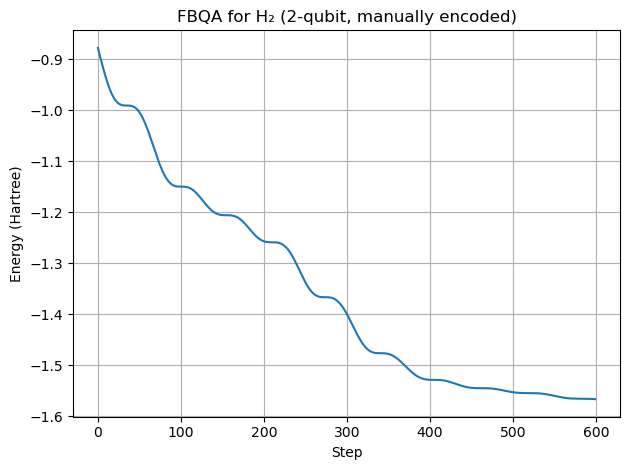

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

# Step 1: 手动定义 H2 的 2-qubit 哈密顿量（sto-3g 基组，0.74Å，Jordan-Wigner 后）
# 来源于 OpenFermion + PySCF + Jordan-Wigner 映射（精确到 1e-3）
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])

# Pauli tensor products
def kron(*args):
    out = args[0]
    for a in args[1:]:
        out = np.kron(out, a)
    return out

H = (
    -1.052373245772859 * kron(I, I) +
     0.39793742484318045 * kron(Z, I) +
     0.39793742484318045 * kron(I, Z) +
    -0.01128010425623538 * kron(Z, Z) +
     0.18093119978423156 * kron(X, X)
)


n_qubits = 2

# Step 2: Driver Hamiltonian H_d = -Y0 - Y1
H_d = - kron(Y, I) - kron(I, Y)

# Step 3: 初始态 |+>^2
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
psi = Statevector.from_instruction(qc).data

# Step 4: commutator 哈密顿量
comm = 1j * (H_d @ H - H @ H_d)

# Step 5: FBQA 主循环
def fbqa_run(H, H_d, comm, psi0, delta_t=0.05, steps=2000, eta=1.0):
    state = psi0
    betas = []
    energies = []

    for k in range(steps):
        beta_k = -eta * delta_t * np.vdot(state, comm @ state).real
        betas.append(beta_k)

        U_c = expm(-1j * H * delta_t)
        U_d = expm(-1j * H_d * beta_k * delta_t)
        state = U_d @ U_c @ state

        energy = np.vdot(state, H @ state).real
        energies.append(energy)

       
        print(f"Step {k+1:4d}: Energy = {energy:.8f}, beta = {beta_k:.5f}")

    return energies, betas

# Step 6: 运行 FBQA
energies, betas = fbqa_run(H, H_d, comm, psi, delta_t=0.05, steps=600, eta=1.0)

# Step 7: 可视化
plt.plot(energies)
plt.xlabel("Step")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA for H₂ (2-qubit, manually encoded)")
plt.grid(True)
plt.tight_layout()
plt.show()


Step    1: E = -0.69210000 Ha, β = -0.000000
Step  101: E = -0.97206843 Ha, β = -0.036329
Step  201: E = -0.98072785 Ha, β = -0.015863
Step  301: E = -0.98272350 Ha, β = -0.008171
Step  401: E = -0.98322559 Ha, β = -0.004435
Step  501: E = -0.98335303 Ha, β = -0.002431
Step  601: E = -0.98338497 Ha, β = -0.001305
Step  701: E = -0.98339280 Ha, β = -0.000671
Step  801: E = -0.98339468 Ha, β = -0.000328
Step  901: E = -0.98339513 Ha, β = -0.000153
Step 1001: E = -0.98339524 Ha, β = -0.000069
Step 1101: E = -0.98339526 Ha, β = -0.000031
Step 1201: E = -0.98339527 Ha, β = -0.000015
Step 1301: E = -0.98339527 Ha, β = -0.000007
Step 1401: E = -0.98339527 Ha, β = -0.000004
Step 1501: E = -0.98339527 Ha, β = -0.000002
Step 1601: E = -0.98339527 Ha, β = -0.000001
Step 1701: E = -0.98339527 Ha, β = -0.000001
Step 1801: E = -0.98339527 Ha, β = -0.000000
Step 1901: E = -0.98339527 Ha, β = -0.000000
Step 2000: E = -0.98339527 Ha, β = -0.000000


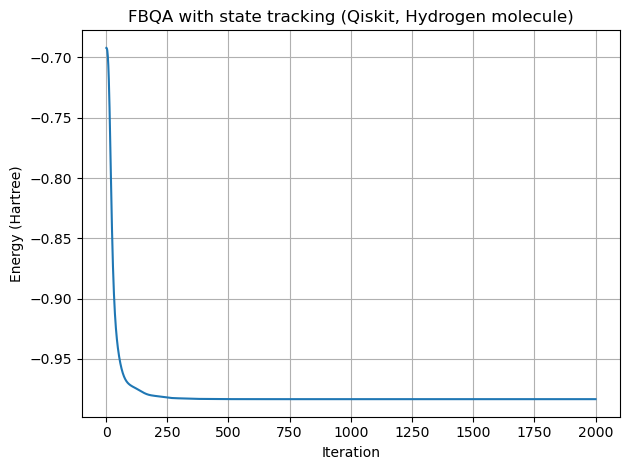

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Step 1: 手动定义 H2 分子的 qubit Hamiltonian（2-qubit）
# Jordan-Wigner 映射后，H2 (sto-3g, 0.74Å) 对应哈密顿量如下：
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)
Y = np.array([[0, -1j], [1j, 0]])

def kron(*args):
    out = args[0]
    for a in args[1:]:
        out = np.kron(out, a)
    return out

H_c = (
    -0.8126 * kron(I, I)
    + 0.1712 * kron(Z, I)
    + 0.1712 * kron(I, Z)
    + 0.1686 * kron(Z, Z)
    + 0.1205 * kron(X, X)
    + 0.1205 * kron(Y, Y)
)

n_qubits = 2

# Step 2: Driver Hamiltonian（与原PennyLane逻辑一致）
H_d = kron(X, I) + kron(I, X)

# Step 3: 构造 commutator 哈密顿量：i[Hd, Hc]
comm_h = 1j * (H_d @ H_c - H_c @ H_d)

# Step 4: 初始化量子态 |+>^n
qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.h(i)
psi = Statevector.from_instruction(qc).data

# Step 5: 单步演化矩阵构造
def single_falqon_unitary(beta_k, delta_t, H_cost, H_driver):
    U_c = expm(-1j * H_cost * delta_t)
    U_d = expm(-1j * H_driver * beta_k * delta_t)
    return U_d @ U_c

# Step 6: 测量期望值
def measure_expectation(state, H):
    return np.real(np.vdot(state, H @ state))

# Step 7: 主循环：FBQA状态跟踪
def run_fbqa_state_tracking(H, H_d, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    state = psi

    for i in range(n_steps):
        # feedback beta
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -1  * exp_comm
        beta_list.append(next_beta)

        # apply unitary
        U_k = single_falqon_unitary(next_beta, delta_t, H, H_d)
        state = U_k @ state

        # measure energy
        energy = measure_expectation(state, H)
        energy_list.append(energy)

        if i % 100 == 0 or i == n_steps - 1:
            print(f"Step {i+1:4d}: E = {energy:.8f} Ha, β = {next_beta:.6f}")

    return beta_list, energy_list

# Step 8: 设置参数并运行
n_steps = 2000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(H_c, H_d, comm_h, n_steps, beta_1, delta_t)

# Step 9: 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA with state tracking (Qiskit, Hydrogen molecule)")
plt.grid(True)
plt.tight_layout()
plt.show()


Qubit Hamiltonian matrix shape: (16, 16)
Step    1: E = -0.09706627 Ha, β = -0.000000
Step  101: E = -0.56263673 Ha, β = -0.008500
Step  201: E = -0.59927255 Ha, β = -0.002134
Step  301: E = -0.60512434 Ha, β = 0.005271
Step  401: E = -0.62771853 Ha, β = 0.005915
Step  501: E = -0.62992168 Ha, β = -0.010187
Step  601: E = -0.65800316 Ha, β = 0.003074
Step  701: E = -0.67602347 Ha, β = 0.011600
Step  801: E = -0.68239358 Ha, β = 0.000103
Step  901: E = -0.68875123 Ha, β = 0.002065
Step 1001: E = -0.69271866 Ha, β = 0.003833
Step 1101: E = -0.69325058 Ha, β = -0.004880
Step 1201: E = -0.69642196 Ha, β = -0.003839
Step 1301: E = -0.69811425 Ha, β = -0.000330
Step 1401: E = -0.69950150 Ha, β = -0.005846
Step 1501: E = -0.70091188 Ha, β = -0.001780
Step 1601: E = -0.70130902 Ha, β = 0.000214
Step 1701: E = -0.70159599 Ha, β = -0.002506
Step 1801: E = -0.70203636 Ha, β = -0.001137
Step 1901: E = -0.70219031 Ha, β = -0.000992
Step 2000: E = -0.70240468 Ha, β = -0.001942


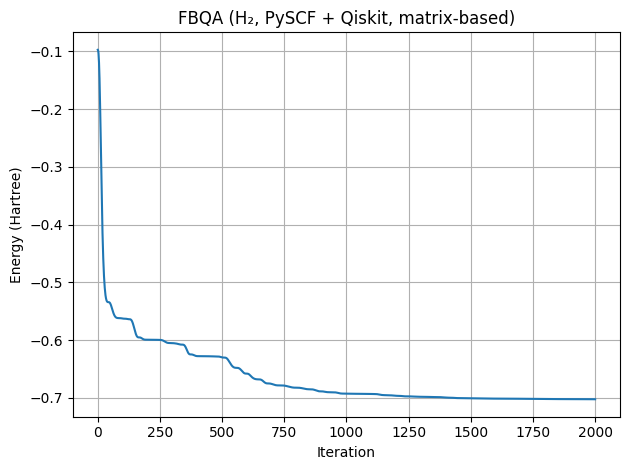

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

from openfermionpyscf import run_pyscf
from openfermion import MolecularData
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

# Step 1: 用 PySCF 构建 H₂ 分子 + 获取 Fermionic Hamiltonian
geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.74))]
basis = "sto-3g"
molecule = MolecularData(geometry, basis, multiplicity=1, charge=0)
molecule = run_pyscf(molecule, run_scf=True)
fermionic_ham = molecule.get_molecular_hamiltonian()

# Step 2: Jordan-Wigner 映射 → qubit Hamiltonian
qubit_ham = jordan_wigner(fermionic_ham)

# Step 3: 转为稀疏矩阵（scipy 格式）
H_c = get_sparse_operator(qubit_ham).toarray()
n_qubits = molecule.n_qubits
print(f"Qubit Hamiltonian matrix shape: {H_c.shape}")

# Step 4: 构造 driver Hamiltonian H_d = ∑ X_i
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
H_d = np.zeros_like(H_c)

def kron(*ops):
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result

for i in range(n_qubits):
    ops = [I] * n_qubits
    ops[i] = X
    H_d += kron(*ops)

# Step 5: 构造 commutator Hamiltonian
comm_h = 1j * (H_d @ H_c - H_c @ H_d)

# Step 6: 初始化 |+>^n 态
qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.h(i)
psi = Statevector.from_instruction(qc).data

# Step 7: 单步 FALQON 演化矩阵
def single_falqon_unitary(beta_k, delta_t, H_cost, H_driver):
    U_cost = expm(-1j * H_cost * delta_t)
    U_driver = expm(-1j * H_driver * beta_k * delta_t)
    return U_driver @ U_cost

# Step 8: 测量期望值
def measure_expectation(state, H):
    return np.real(np.vdot(state, H @ state))

# Step 9: 主流程：状态保留式 FBQA
def run_fbqa_state_tracking(H, H_d, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []
    state = psi

    for i in range(n_steps):
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -1 * delta_t * exp_comm
        beta_list.append(next_beta)

        U_k = single_falqon_unitary(next_beta, delta_t, H, H_d)
        state = U_k @ state

        energy = measure_expectation(state, H)
        energy_list.append(energy)

        if i % 100 == 0 or i == n_steps - 1:
            print(f"Step {i+1:4d}: E = {energy:.8f} Ha, β = {next_beta:.6f}")

    return beta_list, energy_list

# Step 10: 设置参数并运行
n_steps = 2000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(H_c, H_d, comm_h, n_steps, beta_1, delta_t)

# Step 11: 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA (H₂, PySCF + Qiskit, matrix-based)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
import pyscf
print(pyscf.__version__)


2.9.0


In [57]:
import pkg_resources

for dist in pkg_resources.working_set:
    if "qiskit" in dist.project_name.lower():
        print(f"{dist.project_name}: {dist.version}")


qiskit: 2.0.0
qiskit-aer: 0.17.0
qiskit-algorithms: 0.3.1
qiskit-nature: 0.7.2


Step    1: E = -0.69210000 Ha, β = -0.000000
Step  101: E = -0.97206843 Ha, β = -0.036329
Step  201: E = -0.98072785 Ha, β = -0.015863
Step  301: E = -0.98272350 Ha, β = -0.008171
Step  401: E = -0.98322559 Ha, β = -0.004435
Step  501: E = -0.98335303 Ha, β = -0.002431
Step  601: E = -0.98338497 Ha, β = -0.001305
Step  701: E = -0.98339280 Ha, β = -0.000671
Step  801: E = -0.98339468 Ha, β = -0.000328
Step  901: E = -0.98339513 Ha, β = -0.000153
Step 1001: E = -0.98339524 Ha, β = -0.000069
Step 1101: E = -0.98339526 Ha, β = -0.000031
Step 1201: E = -0.98339527 Ha, β = -0.000015
Step 1301: E = -0.98339527 Ha, β = -0.000007
Step 1401: E = -0.98339527 Ha, β = -0.000004
Step 1501: E = -0.98339527 Ha, β = -0.000002
Step 1601: E = -0.98339527 Ha, β = -0.000001
Step 1701: E = -0.98339527 Ha, β = -0.000001
Step 1801: E = -0.98339527 Ha, β = -0.000000
Step 1901: E = -0.98339527 Ha, β = -0.000000
Step 2000: E = -0.98339527 Ha, β = -0.000000


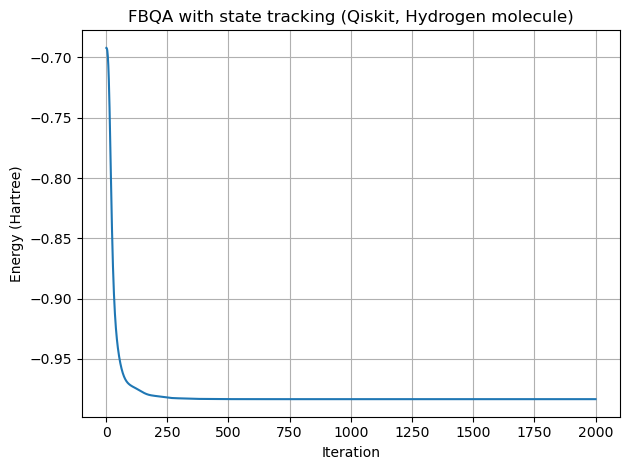

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Step 1: 手动定义 H2 分子的 qubit Hamiltonian（2-qubit）
# Jordan-Wigner 映射后，H2 (sto-3g, 0.74Å) 对应哈密顿量如下：
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
I = np.eye(2)
Y = np.array([[0, -1j], [1j, 0]])

def kron(*args):
    out = args[0]
    for a in args[1:]:
        out = np.kron(out, a)
    return out

H_c = (
    -0.8126 * kron(I, I)
    + 0.1712 * kron(Z, I)
    + 0.1712 * kron(I, Z)
    + 0.1686 * kron(Z, Z)
    + 0.1205 * kron(X, X)
    + 0.1205 * kron(Y, Y)
)

n_qubits = 2

# Step 2: Driver Hamiltonian（与原PennyLane逻辑一致）
H_d = kron(X, I) + kron(I, X)

# Step 3: 构造 commutator 哈密顿量：i[Hd, Hc]
comm_h = 1j * (H_d @ H_c - H_c @ H_d)

# Step 4: 初始化量子态 |+>^n
qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.h(i)
psi = Statevector.from_instruction(qc).data

# Step 5: 单步演化矩阵构造
def single_falqon_unitary(beta_k, delta_t, H_cost, H_driver):
    U_c = expm(-1j * H_cost * delta_t)
    U_d = expm(-1j * H_driver * beta_k * delta_t)
    return U_d @ U_c

# Step 6: 测量期望值
def measure_expectation(state, H):
    return np.real(np.vdot(state, H @ state))

# Step 7: 主循环：FBQA状态跟踪
def run_fbqa_state_tracking(H, H_d, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    state = psi

    for i in range(n_steps):
        # feedback beta
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -1  * exp_comm
        beta_list.append(next_beta)

        # apply unitary
        U_k = single_falqon_unitary(next_beta, delta_t, H, H_d)
        state = U_k @ state

        # measure energy
        energy = measure_expectation(state, H)
        energy_list.append(energy)

        if i % 100 == 0 or i == n_steps - 1:
            print(f"Step {i+1:4d}: E = {energy:.8f} Ha, β = {next_beta:.6f}")

    return beta_list, energy_list

# Step 8: 设置参数并运行
n_steps = 2000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(H_c, H_d, comm_h, n_steps, beta_1, delta_t)

# Step 9: 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA with state tracking (Qiskit, Hydrogen molecule)")
plt.grid(True)
plt.tight_layout()
plt.show()

Step    1: Energy = -0.88947274, beta = -0.00000
Step  101: Energy = -1.05288521, beta = -0.03960
Step  201: Energy = -1.20457448, beta = -0.04009
Step  301: Energy = -1.33565428, beta = 0.00743
Step  401: Energy = -1.42556097, beta = 0.03345
Step  501: Energy = -1.45857795, beta = 0.01442
Step  601: Energy = -1.48697963, beta = -0.01021
Step  701: Energy = -1.49430818, beta = -0.01235
Step  801: Energy = -1.49939028, beta = -0.00113
Step  901: Energy = -1.50167668, beta = 0.00514
Step 1001: Energy = -1.50236733, beta = 0.00293
Step 1101: Energy = -1.50289261, beta = -0.00077
Step 1201: Energy = -1.50304702, beta = -0.00157
Step 1301: Energy = -1.50313048, beta = -0.00051
Step 1401: Energy = -1.50317085, beta = 0.00034
Step 1501: Energy = -1.50318661, beta = 0.00041
Step 1601: Energy = -1.50319423, beta = 0.00011
Step 1701: Energy = -1.50319803, beta = -0.00012
Step 1801: Energy = -1.50319957, beta = -0.00013
Step 1901: Energy = -1.50320026, beta = -0.00001
Step 2001: Energy = -1.50320

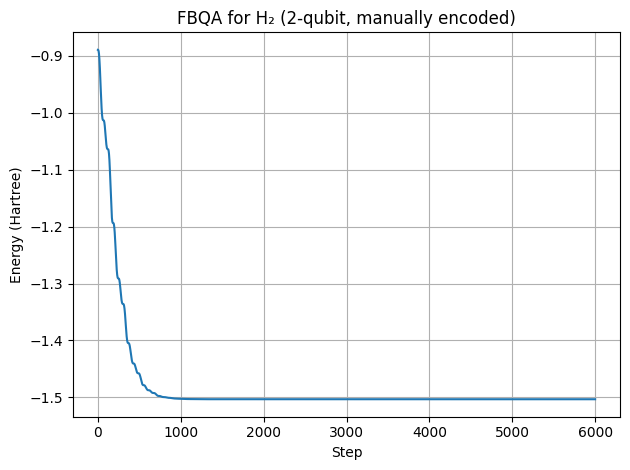

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

# Step 1: 手动定义 H2 的 2-qubit 哈密顿量（sto-3g 基组，0.74Å，Jordan-Wigner 后）
# 来源于 OpenFermion + PySCF + Jordan-Wigner 映射（精确到 1e-3）
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])

# Pauli tensor products
def kron(*args):
    out = args[0]
    for a in args[1:]:
        out = np.kron(out, a)
    return out

H = (
    -1.00383351 * kron(I, I) +
     0.33381404 * kron(Z, I) +
     0.33381404 * kron(I, Z) +
    -0.06438917 * kron(Z, Z) +
     0.11436077 * kron(X, X) +
     0.11436077 * kron(Y, Y)
)



n_qubits = 2

# Step 2: Driver Hamiltonian H_d = -Y0 - Y1
H_d = - kron(X, I) - kron(I, X)


# Step 3: 初始态 |+>^2
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
psi = Statevector.from_instruction(qc).data

# Step 4: commutator 哈密顿量
comm = 1j * (H_d @ H - H @ H_d)

# Step 5: FBQA 主循环
def fbqa_run(H, H_d, comm, psi0, delta_t=0.05, steps=2000, eta=1.0):
    state = psi0
    betas = []
    energies = []

    for k in range(steps):
        beta_k = -eta * delta_t * np.vdot(state, comm @ state).real
        betas.append(beta_k)

        U_c = expm(-1j * H * delta_t)
        U_d = expm(-1j * H_d * beta_k * delta_t)
        state = U_d @ U_c @ state

        energy = np.vdot(state, H @ state).real
        energies.append(energy)

        if k % 100 == 0 or k == steps - 1:
            print(f"Step {k+1:4d}: Energy = {energy:.8f}, beta = {beta_k:.5f}")

    return energies, betas

# Step 6: 运行 FBQA
energies, betas = fbqa_run(H, H_d, comm, psi, delta_t=0.05, steps=6000, eta=1.0)

# Step 7: 可视化
plt.plot(energies)
plt.xlabel("Step")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA for H₂ (2-qubit, manually encoded)")
plt.grid(True)
plt.tight_layout()
plt.show()
